# GLORIA UMAP OOD

In [1]:
# imports
import numpy as np
from importlib import reload

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from datetime import datetime, time
import random 

import pandas
import seaborn as sns

from scipy.spatial import Delaunay
from sklearn import decomposition
import umap

from oceancolor.hydrolight import loisel23
from oceancolor.insitu import gloria
from oceancolor.utils import spectra

In [2]:
#%matplotlib ipympl

# Load up

## GLORIA

In [3]:
reload(gloria)
df_meta, df_Rrs, df_Rrs_std, df_qc_flags = gloria.load_gloria()

Loading GLORIA dataset...


In [4]:
gloria_wv, gloria_Rrs, _ = gloria.parse_table(df_Rrs, 'Rrs')
_, gloria_Rrs_std, _ = gloria.parse_table(df_Rrs_std, 'Rrs_std')

## L23

In [5]:
X,Y = 4,0
l23_ds = loisel23.load_ds(X, Y)

# Wavelengths, restricted to > 400 nm
#cut = (l23_ds.Lambda > min_wv) & (l23_ds.Lambda < high_cut)
l23_a = l23_ds.a.data[:]
l23_wave = l23_ds.Lambda.data

l23_Rs = l23_ds.Rrs.data[:]

# Rebin/cut GLORIA to L23

In [6]:
new_gloria_wv = np.append(l23_wave, [l23_wave.max()+5.]) - 2.5 # Because the rebinning is not interpolation
#
rwv_nm, gloria_rebin, gloria_rebin_sig = spectra.rebin_to_grid(gloria_wv, gloria_Rrs, gloria_Rrs_std, new_gloria_wv)

/home/xavier/Projects/Oceanography/python/ocean-color/oceancolor/utils/spectra.py:66: RuntimeWarning: invalid value encountered in divide
  isum = np.nansum(values[gd]*mask[gd], axis=0) / mask_sum
/home/xavier/Projects/Oceanography/python/ocean-color/oceancolor/utils/spectra.py:67: RuntimeWarning: invalid value encountered in divide
  esum = np.nansum(err_vals[gd]*mask[gd], axis=0) / mask_sum


## Clean up

In [7]:
bad_Rs = np.where(np.isnan(gloria_rebin))

In [8]:
keep_gloria = np.ones(gloria_rebin.shape[0], dtype=bool)
bad_rows = np.unique(bad_Rs[0])
keep_gloria[bad_rows] = False

In [9]:
np.sum(keep_gloria)

1957

In [10]:
l23_Rs.shape

(3320, 81)

# UMAP

In [11]:
reducer_umap = umap.UMAP(random_state=42)
latents_mapping = reducer_umap.fit(l23_Rs)

/home/xavier/miniconda3/envs/os_11/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


## Embed

In [12]:
l23_embedding = latents_mapping.transform(l23_Rs)

In [13]:
gloria_embedding = latents_mapping.transform(gloria_rebin[keep_gloria])

In [14]:
gloria_embedding.shape

(1957, 2)

# Examine

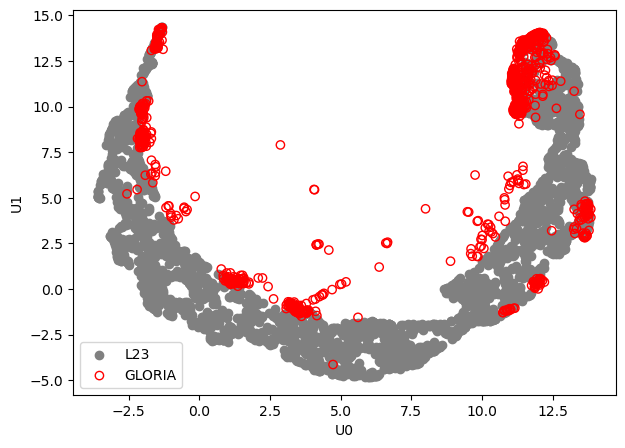

In [19]:

fig = plt.figure(figsize=(7,5))

plt.clf()
ax = plt.gca()
ax.scatter(l23_embedding[:,0], l23_embedding[:,1], color='gray', label='L23')
ax.scatter(gloria_embedding[:,0], gloria_embedding[:,1], facecolor='None', edgecolor='red', label='GLORIA')
#
ax.set_xlabel('U0')
ax.set_ylabel('U1')
ax.legend()
#
plt.show()